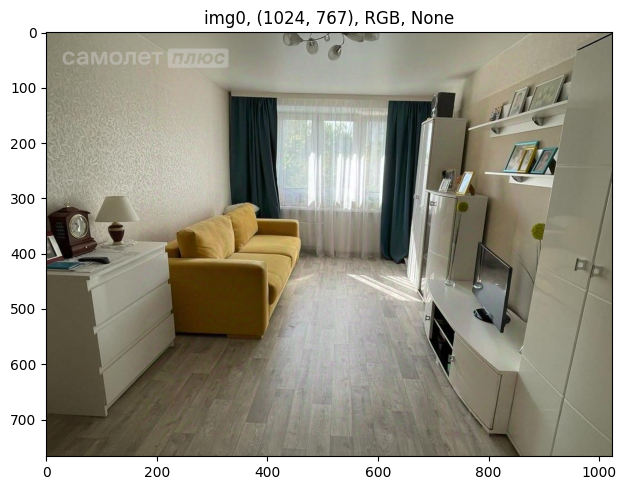

In [1]:
import cv2
import torch
import numpy as np
from PIL import Image
from utils import display_images


DEVICE = 'cuda:0'
CACHE_DIR = '/home/a.lugovoi/Git/rnd-tasks/generative-ai-research/cache'
img_pil = Image.open('data/img5001_BDorig.png').convert('RGB')
display_images([img_pil])

# Step 1: simple img2img

## img2img stable-diffusion-v15
- https://huggingface.co/docs/diffusers/en/using-diffusers/img2img#stable-diffusion-v15

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

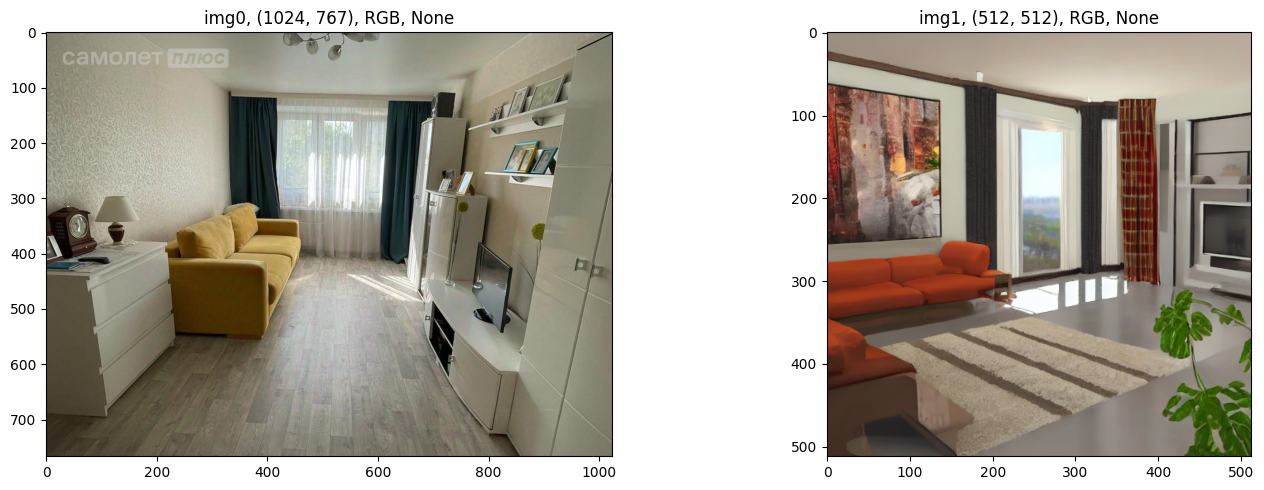

CPU times: user 7.81 s, sys: 697 ms, total: 8.51 s
Wall time: 7.45 s


In [29]:
%%time

from diffusers import AutoPipelineForImage2Image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    cache_dir=CACHE_DIR
).to(DEVICE)

prompt = "New modern style of livingroom, warm color palette, detailed, 8k"
img_gen = pipe(prompt, image=img_pil.resize((512, 512)), strenght=0.7, num_inference_steps=100)
display_images([img_pil] + img_gen.images)

## img2img stable-diffusion-xl-sdxl
- https://huggingface.co/docs/diffusers/en/using-diffusers/img2img#stable-diffusion-xl-sdxl

/home/a.lugovoi/.conda/envs/a.lugovoi.py310/lib/python3.10/site-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
2024-04-24 18:59:26.020459: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-24 18:59:26.023576: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-24 18:59:26.082846: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations,

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

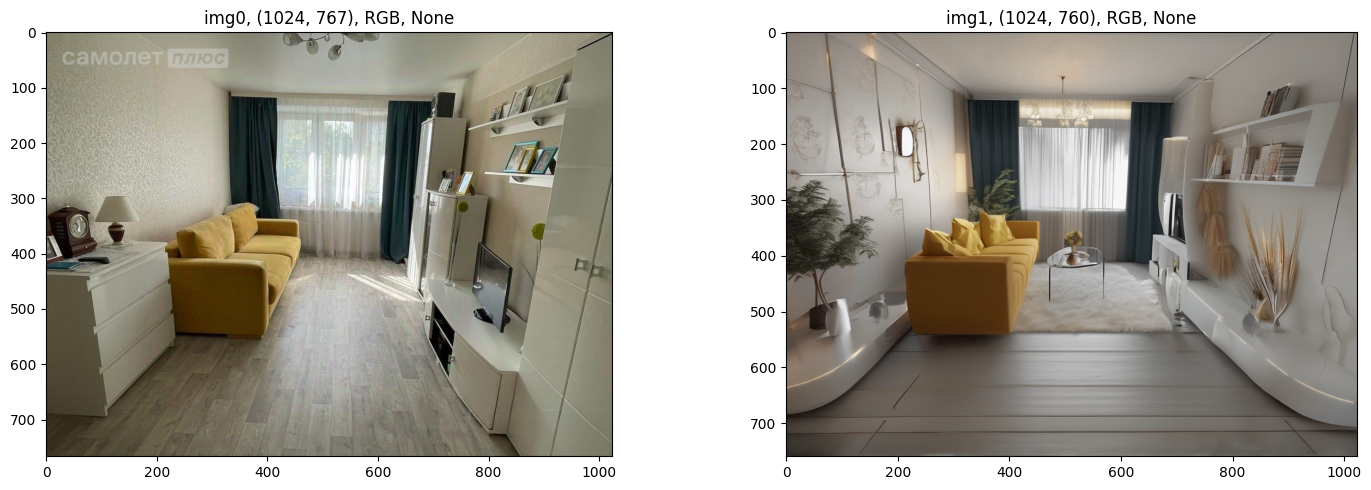

CPU times: user 19 s, sys: 6.94 s, total: 26 s
Wall time: 19.9 s


In [2]:
%%time

from diffusers import AutoPipelineForImage2Image

pipe = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", 
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    cache_dir=CACHE_DIR
).to(DEVICE)

prompt = "New modern style of livingroom, warm color palette, detailed, 8k"

img_gen = pipe(prompt, image=img_pil, strength=0.7, num_inference_steps=100)
display_images([img_pil] + img_gen.images)

# Step 2: ControlNet txt2img

## monster-labs/control_v1p_sd15_qrcode_monster

- https://huggingface.co/monster-labs/control_v1p_sd15_qrcode_monster

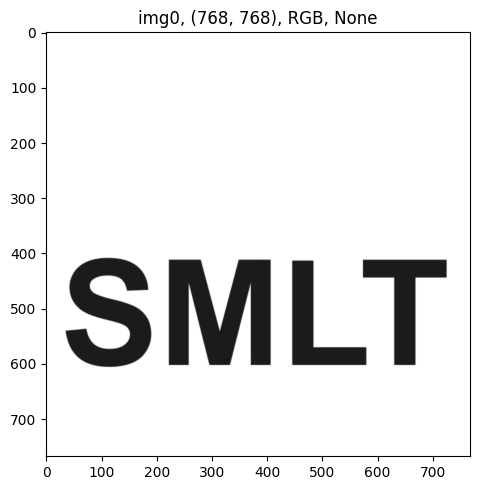

In [40]:
img_pil = Image.open('data/img5002_SMLT.png').convert('RGB')
display_images([img_pil])

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

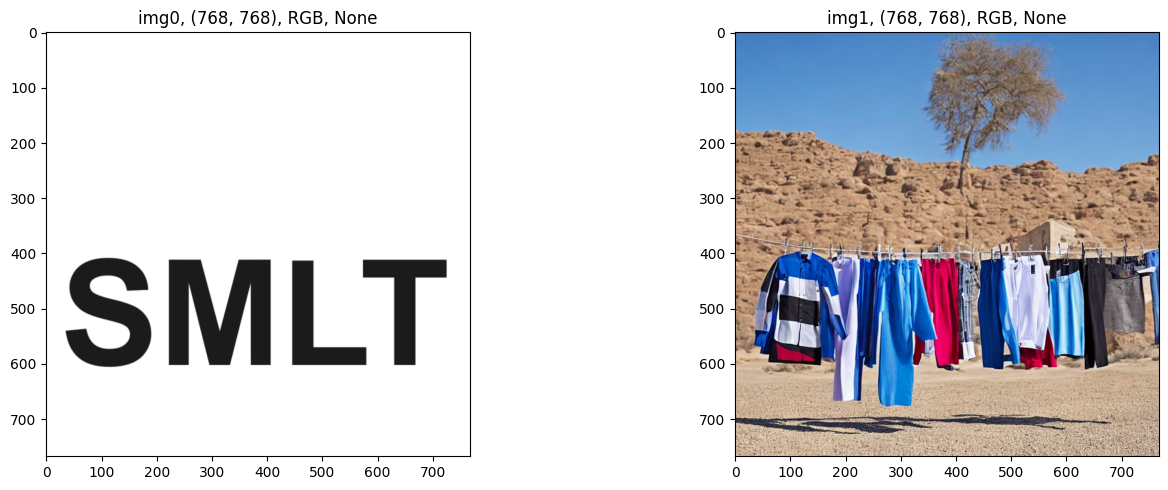

CPU times: user 32.1 s, sys: 12.8 s, total: 44.9 s
Wall time: 18.6 s


In [48]:
%%time

from diffusers import StableDiffusionControlNetPipeline, UniPCMultistepScheduler, ControlNetModel

controlnet = ControlNetModel.from_pretrained(
    "monster-labs/control_v1p_sd15_qrcode_monster",
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
	"runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,
    controlnet=controlnet,
    cache_dir=CACHE_DIR
).to(DEVICE)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_model_cpu_offload() # no explicit tocuda()
# pipe.enable_xformers_memory_efficient_attention()

prompt = ["award winning photography shirts, pants, socks, linens, sheets on clothesline in the sun high definition"]
negative_prompt = ["ugly. disfigured. low quality. blurry. nsfw. trees. green leaves. leaf. vegetation. paint. oil painting"] 

img_gen = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=img_pil,
    guidance_scale=9,
    controlnet_conditioning_scale=1.2,
    height=768,  # cause init image such size
    width=768,
    generator=torch.Generator(DEVICE).manual_seed(22),
    num_inference_steps=100
)
display_images([img_pil] + img_gen.images)

## diffusers/controlnet-canny-sdxl-1.0

- https://huggingface.co/docs/diffusers/en/api/pipelines/controlnet_sdxl#diffusers.StableDiffusionXLControlNetPipeline.__call__.example

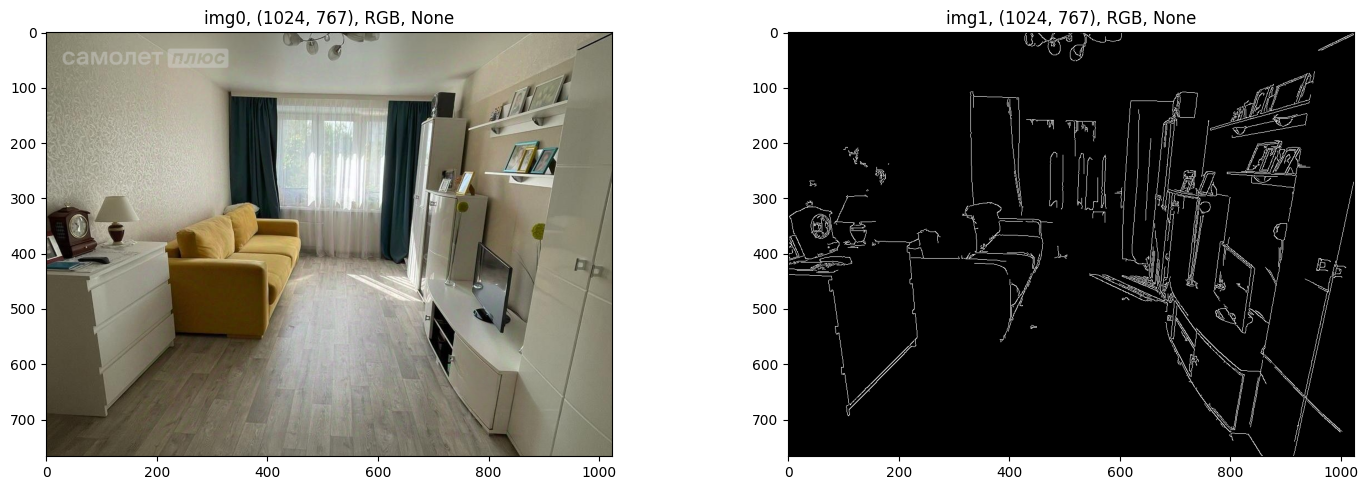

In [11]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

img_canny = np.array(img_pil).copy()
img_canny = cv2.Canny(img_canny, 100, 300)
img_canny = img_canny[:, :, None]
img_canny = np.concatenate([img_canny, img_canny, img_canny], axis=2)
img_canny = Image.fromarray(img_canny)
display_images([img_pil, img_canny])

In [12]:
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0",
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)
# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16, cache_dir=CACHE_DIR)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    # vae=vae,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)
# pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

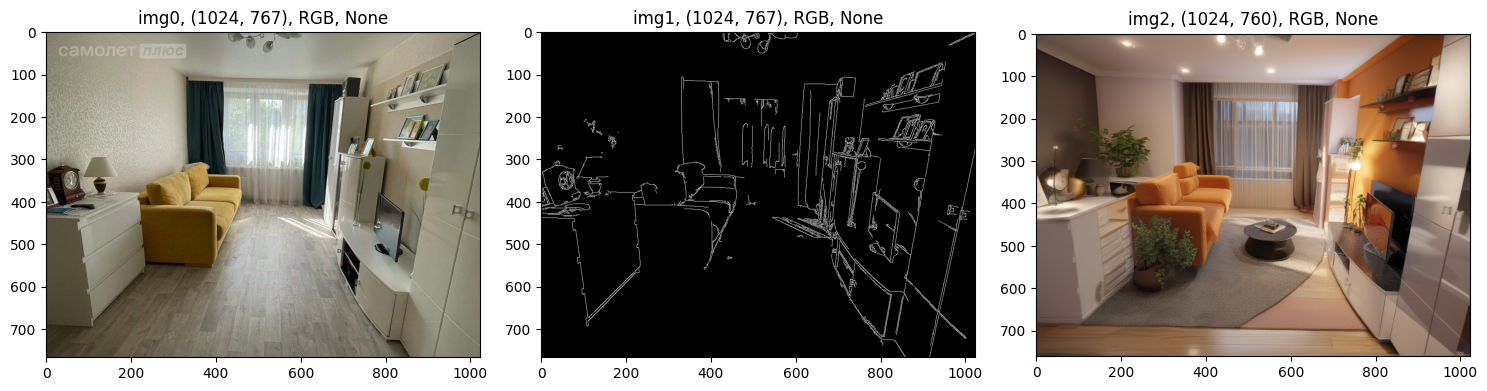

CPU times: user 26.4 s, sys: 3.94 s, total: 30.3 s
Wall time: 29.3 s


In [15]:
%%time

prompt = ["New modern style of livingroom, warm color palette, detailed, 8k"]
negative_prompt = ["low quality, bad quality, sketches"]

img_gen = pipe(
    prompt, 
    negative_prompt=negative_prompt, 
    image=img_canny, 
    controlnet_conditioning_scale=0.6,
    guidance_scale=9,
    eta=0.0,
    generator=torch.Generator(DEVICE).manual_seed(2),
    num_inference_steps=100
)

display_images([img_pil, img_canny] + img_gen.images)

## diffusers/controlnet-depth-sdxl-1.0

- https://huggingface.co/diffusers/controlnet-depth-sdxl-1.0

- for the depth map we will use dpt-beit-large-512 model instead dpt-hybrid-midas (as in the example with diffusers)
- the benchmark of the depth models: https://github.com/isl-org/MiDaS/tree/master

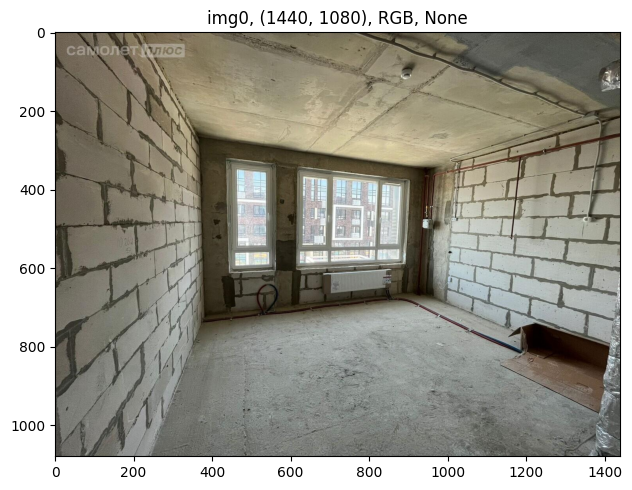

In [4]:
img_pil = Image.open('data/img5003_PrimaryHouse.jpg').convert('RGB')
display_images([img_pil])

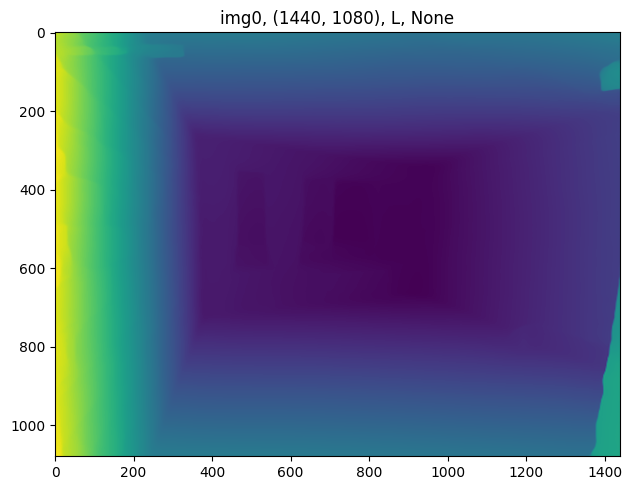

CPU times: user 1min 30s, sys: 29.1 s, total: 1min 59s
Wall time: 3.43 s


In [15]:
%%time

from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL


processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)#.to(DEVICE)

# prepare image for the model
inputs = processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img_pil.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
img_depth = Image.fromarray(formatted)
display_images([img_depth])

In [16]:
%%time

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

# vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to(DEVICE)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    # vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)
# pipe.enable_model_cpu_offload()

# pipe.load_lora_weights('/home/a.lugovoi/Git/rnd-tasks/generative-ai/models/tuned/MODEL_STYLE1/5000/pytorch_lora_weights.safetensors')
# pipe = pipe.to(DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 2.35 s, sys: 926 ms, total: 3.28 s
Wall time: 3.8 s


  0%|          | 0/100 [00:00<?, ?it/s]

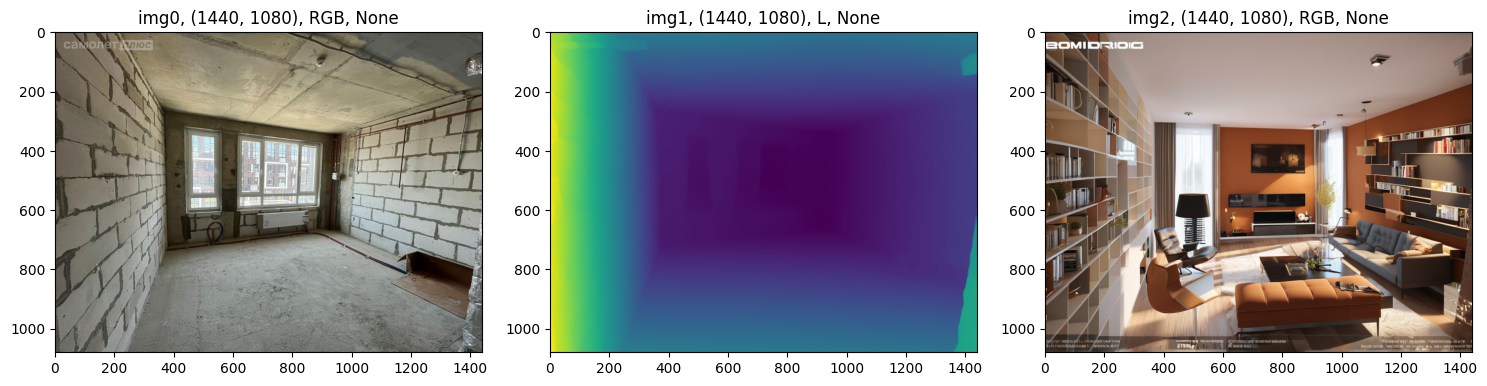

CPU times: user 38.9 s, sys: 11.8 s, total: 50.8 s
Wall time: 49.7 s


In [17]:
%%time

prompt = ["New modern style of livingroom, warm color palette, detailed, 8k"]
negative_prompt = ["low quality, bad quality, sketches"]

img_gen = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=img_depth,
    guidance_scale=13,
    num_images_per_prompt=1,
    num_inference_steps=100, 
    controlnet_conditioning_scale=0.5,
    generator = torch.Generator(DEVICE).manual_seed(8)
)

display_images([img_pil, img_depth] + img_gen.images)

## StableDiffusionXLControlNetImg2ImgPipeline

- https://huggingface.co/docs/diffusers/api/pipelines/controlnet_sdxl#diffusers.StableDiffusionXLControlNetImg2ImgPipeline

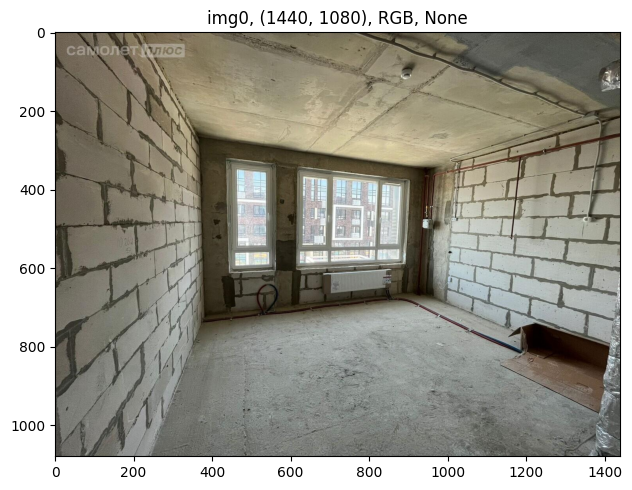

In [2]:
img_pil = Image.open('data/img5003_PrimaryHouse.jpg').convert('RGB')
display_images([img_pil])

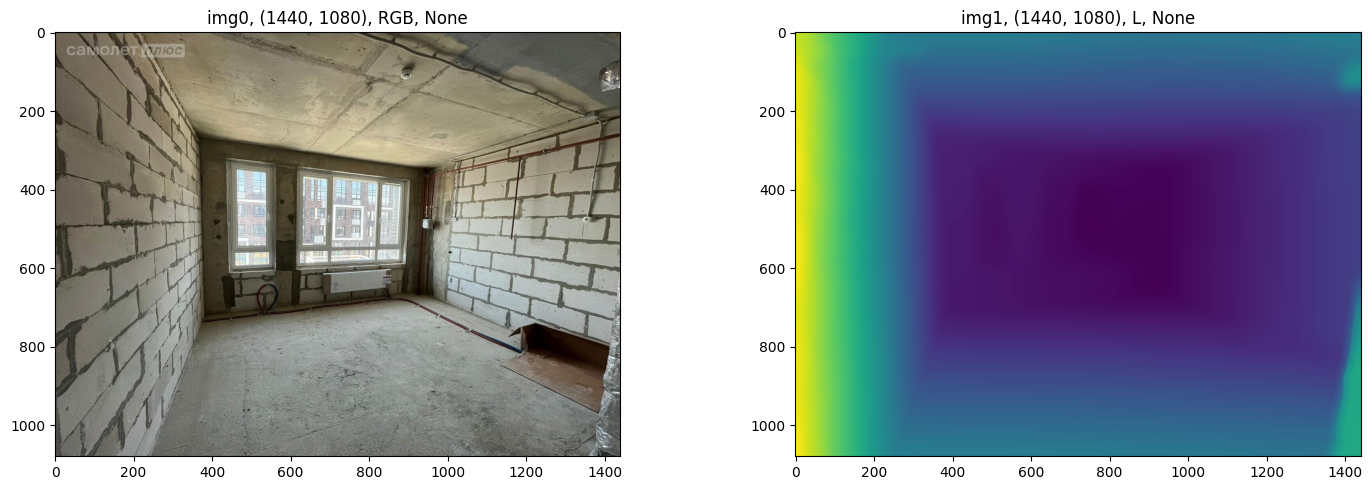

CPU times: user 1min 6s, sys: 3.9 s, total: 1min 10s
Wall time: 3.3 s


In [6]:
%%time

from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetImg2ImgPipeline


processor = DPTImageProcessor.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-beit-large-512", cache_dir=CACHE_DIR)#.to(DEVICE)

# prepare image for the model
inputs = processor(images=img_pil, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# interpolate to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=img_pil.size[::-1],
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")

formatted = cv2.bilateralFilter(formatted, 50, 90, 90)

img_depth = Image.fromarray(formatted)
display_images([img_pil, img_depth])

In [7]:
%%time

controlnet = ControlNetModel.from_pretrained(
    'diffusers/controlnet-depth-sdxl-1.0-small',
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

pipe = StableDiffusionXLControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    controlnet=controlnet,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
    cache_dir=CACHE_DIR
).to(DEVICE)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

CPU times: user 2.55 s, sys: 751 ms, total: 3.3 s
Wall time: 3.8 s


  0%|          | 0/90 [00:00<?, ?it/s]

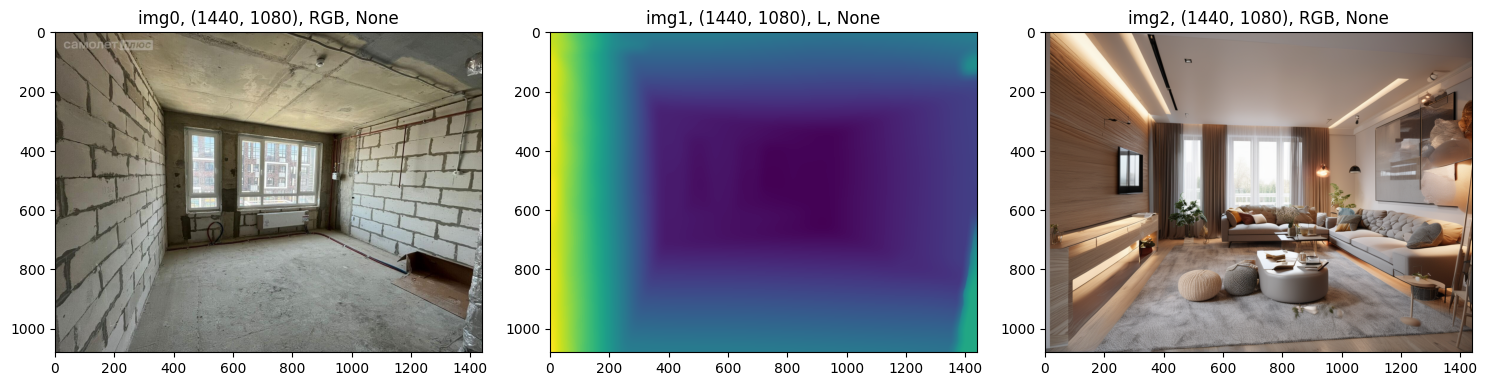

CPU times: user 33.4 s, sys: 6.5 s, total: 39.9 s
Wall time: 38.2 s


In [8]:
%%time

prompt = ["New modern style of livingroom, warm color palette, detailed, 8k"]
negative_prompt = ["low quality, bad quality, sketches"]

img_gen = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=img_pil,
    control_image=img_depth,
    strength=0.9,
    eta=0.0,
    num_inference_steps=100,
    controlnet_conditioning_scale=0.4,
    guidance_scale=12,
    num_images_per_prompt=1,
    generator = torch.Generator(DEVICE).manual_seed(21)
)

display_images([img_pil, img_depth] + img_gen.images)